In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-dataset/item_properties_part1.csv
/kaggle/input/ecommerce-dataset/category_tree.csv
/kaggle/input/ecommerce-dataset/item_properties_part2.csv
/kaggle/input/ecommerce-dataset/events.csv


In [2]:
# Libraries 


import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt



# **Analyzing-Purchasing-Patterns**


## Introduction



## Objectives

- The main goal is to find abnormal users of e-shop.
- Identify customer purchasing patterns to create better marketing strategies.
- Analyze product popularity to improve inventory management.


## Load Data

In [3]:

# Read the CSV files
events = pl.read_csv("/kaggle/input/ecommerce-dataset/events.csv")
category_tree = pl.read_csv("/kaggle/input/ecommerce-dataset/category_tree.csv")
item_properties_part1 = pl.read_csv("/kaggle/input/ecommerce-dataset/item_properties_part1.csv")
item_properties_part2 = pl.read_csv("/kaggle/input/ecommerce-dataset/item_properties_part2.csv")

# Combine item_properties into a single DataFrame
item_properties = pl.concat([item_properties_part1, item_properties_part2], how="vertical")
events_copy = events.clone()


# Print summaries to verify
print("Events DataFrame:")
print(events.head())

print("\nCategory Tree DataFrame:")
print(category_tree.head())

print("\nItem Properties DataFrame (Combined):")
print(item_properties.head())


Events DataFrame:
shape: (5, 5)
┌───────────────┬───────────┬───────┬────────┬───────────────┐
│ timestamp     ┆ visitorid ┆ event ┆ itemid ┆ transactionid │
│ ---           ┆ ---       ┆ ---   ┆ ---    ┆ ---           │
│ i64           ┆ i64       ┆ str   ┆ i64    ┆ str           │
╞═══════════════╪═══════════╪═══════╪════════╪═══════════════╡
│ 1433221332117 ┆ 257597    ┆ view  ┆ 355908 ┆ null          │
│ 1433224214164 ┆ 992329    ┆ view  ┆ 248676 ┆ null          │
│ 1433221999827 ┆ 111016    ┆ view  ┆ 318965 ┆ null          │
│ 1433221955914 ┆ 483717    ┆ view  ┆ 253185 ┆ null          │
│ 1433221337106 ┆ 951259    ┆ view  ┆ 367447 ┆ null          │
└───────────────┴───────────┴───────┴────────┴───────────────┘

Category Tree DataFrame:
shape: (5, 2)
┌────────────┬──────────┐
│ categoryid ┆ parentid │
│ ---        ┆ ---      │
│ i64        ┆ i64      │
╞════════════╪══════════╡
│ 1016       ┆ 213      │
│ 809        ┆ 169      │
│ 570        ┆ 9        │
│ 1691       ┆ 885      │
│

## Explore the Data

- Get column names and data types:

In [4]:
print(events.schema, "\n")
print(category_tree.schema,  "\n")
print(item_properties.schema,  "\n")



Schema([('timestamp', Int64), ('visitorid', Int64), ('event', String), ('itemid', Int64), ('transactionid', String)]) 

Schema([('categoryid', Int64), ('parentid', Int64)]) 

Schema([('timestamp', Int64), ('itemid', Int64), ('property', String), ('value', String)]) 



- Check for missing values in the datasets:



In [5]:
print(events.null_count())
print(category_tree.null_count())
print(item_properties.null_count())


shape: (1, 5)
┌───────────┬───────────┬───────┬────────┬───────────────┐
│ timestamp ┆ visitorid ┆ event ┆ itemid ┆ transactionid │
│ ---       ┆ ---       ┆ ---   ┆ ---    ┆ ---           │
│ u32       ┆ u32       ┆ u32   ┆ u32    ┆ u32           │
╞═══════════╪═══════════╪═══════╪════════╪═══════════════╡
│ 0         ┆ 0         ┆ 0     ┆ 0      ┆ 2733644       │
└───────────┴───────────┴───────┴────────┴───────────────┘
shape: (1, 2)
┌────────────┬──────────┐
│ categoryid ┆ parentid │
│ ---        ┆ ---      │
│ u32        ┆ u32      │
╞════════════╪══════════╡
│ 0          ┆ 25       │
└────────────┴──────────┘
shape: (1, 4)
┌───────────┬────────┬──────────┬───────┐
│ timestamp ┆ itemid ┆ property ┆ value │
│ ---       ┆ ---    ┆ ---      ┆ ---   │
│ u32       ┆ u32    ┆ u32      ┆ u32   │
╞═══════════╪════════╪══════════╪═══════╡
│ 0         ┆ 0      ┆ 0        ┆ 0     │
└───────────┴────────┴──────────┴───────┘


- Get summary statistics:



In [6]:
events.describe()


statistic,timestamp,visitorid,event,itemid,transactionid
str,f64,f64,str,f64,str
"""count""",2.756101e6,2.756101e6,"""2756101""",2.756101e6,"""22457"""
"""null_count""",0.0,0.0,"""0""",0.0,"""2733644"""
"""mean""",1.4364e12,701922.883229,null,234922.478375,null
"""std""",3.3663e9,405687.520809,null,134195.425214,null
"""min""",1.4306e12,0.0,"""addtocart""",3.0,"""0"""
"""25%""",1.4335e12,350566.0,null,118120.0,null
"""50%""",1.4365e12,702060.0,null,236067.0,null
"""75%""",1.4392e12,1.053437e6,null,350715.0,null
"""max""",1.4425e12,1.407579e6,"""view""",466867.0,"""9999"""


In [7]:
item_properties.describe()

statistic,timestamp,itemid,property,value
str,f64,f64,str,str
"""count""",2.0275902e7,2.0275902e7,"""20275902""","""20275902"""
"""null_count""",0.0,0.0,"""0""","""0"""
"""mean""",1.4352e12,233390.432525,null,null
"""std""",3.3278e9,134845.230668,null,null
"""min""",1.4312e12,0.0,"""0""","""0"""
"""25%""",1.4324e12,116516.0,null,null
"""50%""",1.4336e12,233483.0,null,null
"""75%""",1.4379e12,350304.0,null,null
"""max""",1.4421e12,466866.0,"""categoryid""","""nInfinity"""


- Count the frequency of each event type:


### Event Distribution




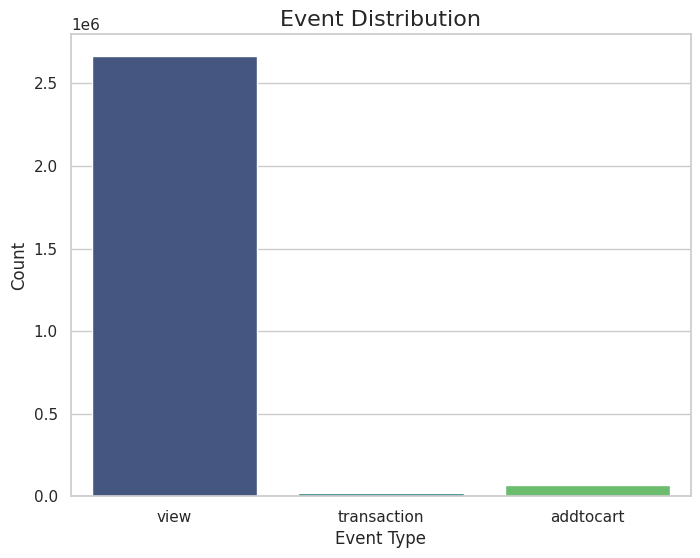

In [8]:
event_counts = events.group_by("event").agg(pl.count("event").alias("count"))

# Convert Polars DataFrame to Pandas DataFrame
event_counts_df = event_counts.to_pandas()

# Set Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=event_counts_df, x="event", y="count", palette="viridis")

# Add title and labels
plt.title("Event Distribution", fontsize=16)
plt.xlabel("Event Type", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show the plot
plt.show()



In [9]:
total_views = events.filter(pl.col("event") == "view").shape[0]

# Step 2: Aggregate counts for all events
event_counts = (
    events.group_by("event")
    .agg(pl.count("event").alias("count"))
    .with_columns(
        # Step 3: Add percentage column
        (pl.col("count") / total_views * 100).alias("percent_of_purchases")
    )
)


print(event_counts)
print( np.round( event_counts["percent_of_purchases"], 2))


shape: (3, 3)
┌─────────────┬─────────┬──────────────────────┐
│ event       ┆ count   ┆ percent_of_purchases │
│ ---         ┆ ---     ┆ ---                  │
│ str         ┆ u32     ┆ f64                  │
╞═════════════╪═════════╪══════════════════════╡
│ view        ┆ 2664312 ┆ 100.0                │
│ addtocart   ┆ 69332   ┆ 2.602248             │
│ transaction ┆ 22457   ┆ 0.842882             │
└─────────────┴─────────┴──────────────────────┘
[100.     2.6    0.84]


- 0.84% of viewers made a purchase.
- 2.60% of viewers added items to the cart.
- 32.39% of those who added items to the cart completed a purchase.

( include in same graph)


### Identify Customer Purchasing Patterns

- Filter purchase events and group by visitorid:


In [10]:
top_customers = (
    events.filter(pl.col("event") == "transaction")
    .group_by("visitorid")
    .agg(pl.count("event").alias("purchase_count"))
    .sort("purchase_count", descending=True)
)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


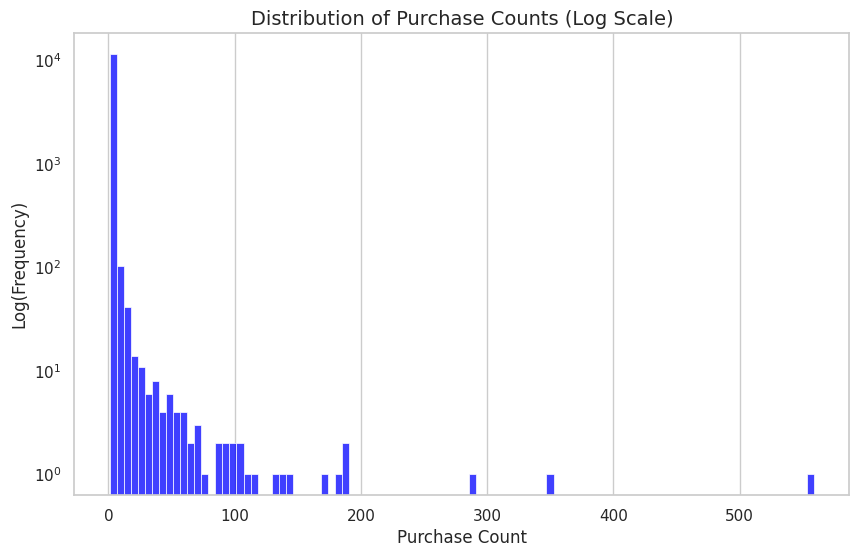

In [11]:


# Convert Polars DataFrame to Pandas DataFrame
top_customers_df = top_customers.to_pandas()

# Plot Histogram with Logarithmic y-axis
plt.figure(figsize=(10, 6))
sns.histplot(
    top_customers_df["purchase_count"], 
    bins=100, 
    kde=False, 
    color="blue"
)
plt.yscale("log")
plt.title("Distribution of Purchase Counts (Log Scale)", fontsize=14)
plt.xlabel("Purchase Count", fontsize=12)
plt.ylabel("Log(Frequency)", fontsize=12)
plt.grid(axis='y')
plt.show()


- contribution of top customers.

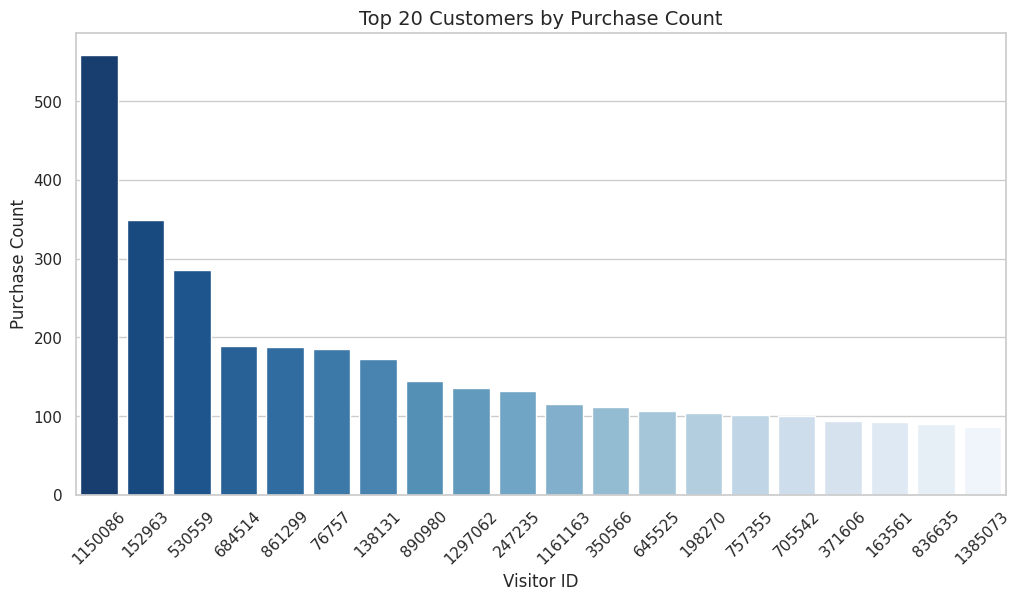

In [12]:
# Sort by purchase_count
top_n = top_customers_df.nlargest(20, "purchase_count")

# Plot Pareto Chart
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_n["visitorid"].astype(str), 
    y=top_n["purchase_count"], 
    palette="Blues_r"
)
plt.title("Top 20 Customers by Purchase Count", fontsize=14)
plt.xlabel("Visitor ID", fontsize=12)
plt.ylabel("Purchase Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()


###  Peak Purchase Times

*Time-Based Analysis*
    
- Analyze peak purchase times:

In [13]:
import polars as pl

# Assuming 'events' is a Polars DataFrame
events = events.with_columns(pl.col("timestamp").cast(pl.Datetime))
purchase_times = (
    events.filter(pl.col("event") == "transaction")
    .with_columns(pl.col("timestamp").dt.hour().alias("hour"))  # Ensure .hour() is used as a method
    .group_by("hour")
    .agg(pl.count("event").alias("purchase_count"))
    .sort("hour")
)
print(purchase_times)


shape: (4, 2)
┌──────┬────────────────┐
│ hour ┆ purchase_count │
│ ---  ┆ ---            │
│ i8   ┆ u32            │
╞══════╪════════════════╡
│ 13   ┆ 4100           │
│ 14   ┆ 7003           │
│ 15   ┆ 7018           │
│ 16   ┆ 4336           │
└──────┴────────────────┘


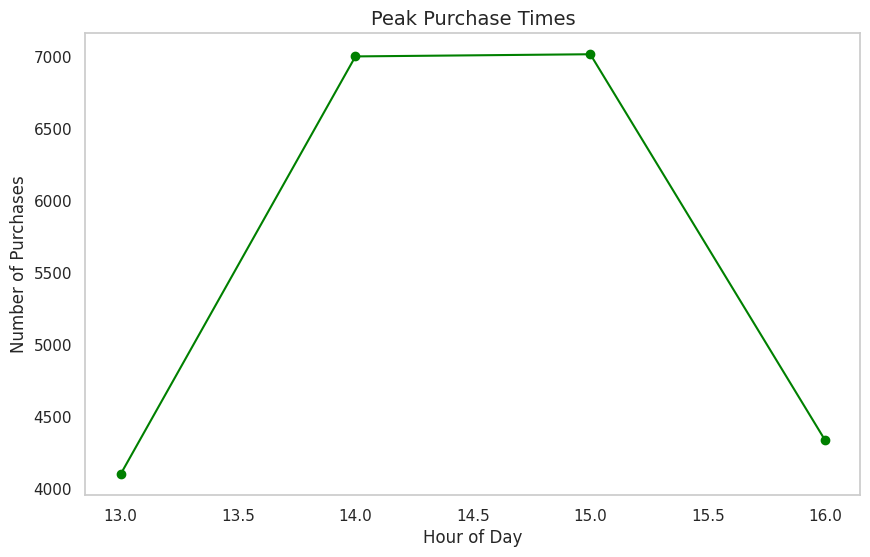

In [14]:
purchase_times_dict = purchase_times.to_pandas().set_index("hour")["purchase_count"].to_dict()

plt.figure(figsize=(10, 6))
plt.plot(list(purchase_times_dict.keys()), list(purchase_times_dict.values()), marker='o', color='green')
plt.title("Peak Purchase Times", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Purchases", fontsize=12)
plt.grid()
plt.show()


Customer Journey

- Track customer interactions (e.g., views → add to cart → purchase):



In [15]:
journey = (
    events.group_by(["visitorid", "event"])
    .agg(pl.count("event").alias("count"))
    .pivot(
        values="count",
        index="visitorid",
        columns="event",
        aggregate_function="sum",
    )
    .fill_null(0)
)
print(journey)


/tmp/ipykernel_17/3667335924.py:2: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  events.group_by(["visitorid", "event"])


shape: (1_407_580, 4)
┌───────────┬──────┬───────────┬─────────────┐
│ visitorid ┆ view ┆ addtocart ┆ transaction │
│ ---       ┆ ---  ┆ ---       ┆ ---         │
│ i64       ┆ u32  ┆ u32       ┆ u32         │
╞═══════════╪══════╪═══════════╪═════════════╡
│ 970638    ┆ 1    ┆ 0         ┆ 0           │
│ 839382    ┆ 1    ┆ 0         ┆ 0           │
│ 1105604   ┆ 1    ┆ 0         ┆ 0           │
│ 1175941   ┆ 20   ┆ 0         ┆ 1           │
│ 679074    ┆ 1    ┆ 0         ┆ 0           │
│ …         ┆ …    ┆ …         ┆ …           │
│ 150171    ┆ 1    ┆ 0         ┆ 0           │
│ 971174    ┆ 1    ┆ 0         ┆ 0           │
│ 1041908   ┆ 1    ┆ 0         ┆ 0           │
│ 84600     ┆ 2    ┆ 0         ┆ 0           │
│ 1055512   ┆ 1    ┆ 0         ┆ 0           │
└───────────┴──────┴───────────┴─────────────┘


## Analyze Product Popularity

### Top-Selling Products

- Find the most purchased products:


shape: (12_025, 2)
┌────────┬────────────────┐
│ itemid ┆ purchase_count │
│ ---    ┆ ---            │
│ i64    ┆ u32            │
╞════════╪════════════════╡
│ 461686 ┆ 133            │
│ 119736 ┆ 97             │
│ 213834 ┆ 92             │
│ 7943   ┆ 46             │
│ 312728 ┆ 46             │
│ …      ┆ …              │
│ 314657 ┆ 1              │
│ 88672  ┆ 1              │
│ 104815 ┆ 1              │
│ 333191 ┆ 1              │
│ 432927 ┆ 1              │
└────────┴────────────────┘


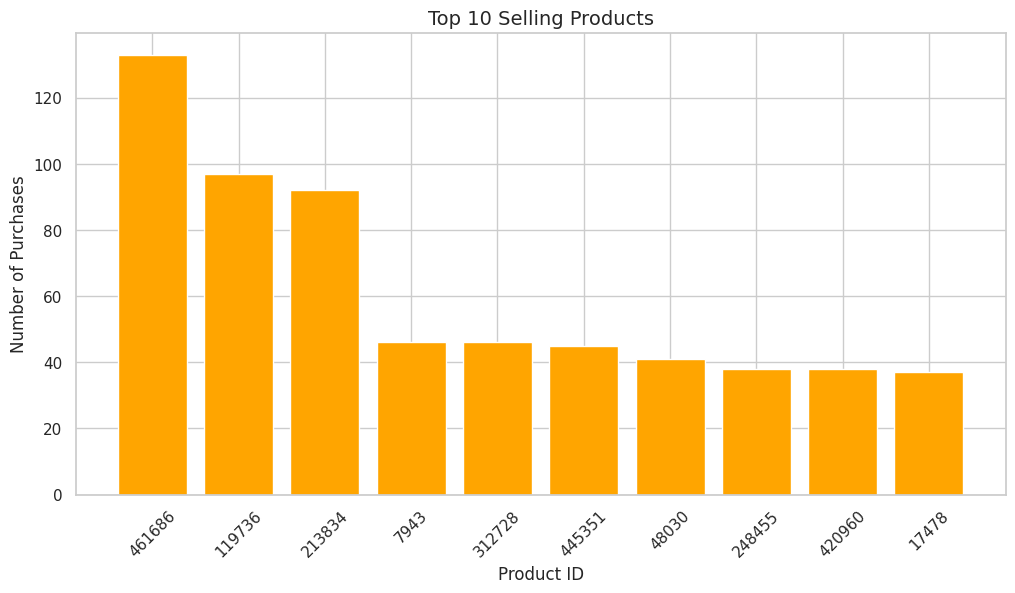

In [16]:
top_products = (
    events.filter(pl.col("event") == "transaction")
    .group_by("itemid")
    .agg(pl.count("event").alias("purchase_count"))
    .sort("purchase_count", descending=True)
)
print(top_products)


top_products_df = top_products.head(10).to_pandas()
plt.figure(figsize=(12, 6))
plt.bar(top_products_df["itemid"].astype(str), top_products_df["purchase_count"], color='orange')
plt.title("Top 10 Selling Products", fontsize=14)
plt.xlabel("Product ID", fontsize=12)
plt.ylabel("Number of Purchases", fontsize=12)
plt.xticks(rotation=45)
plt.show()


###  Category Popularity


shape: (1_156, 2)
┌───────┬─────────────┐
│ value ┆ event_count │
│ ---   ┆ ---         │
│ str   ┆ u32         │
╞═══════╪═════════════╡
│ 1613  ┆ 477838      │
│ 491   ┆ 362920      │
│ 1120  ┆ 229824      │
│ 1509  ┆ 141887      │
│ 1277  ┆ 111325      │
│ …     ┆ …           │
│ 732   ┆ 1           │
│ 301   ┆ 1           │
│ 621   ┆ 1           │
│ 180   ┆ 1           │
│ 1406  ┆ 1           │
└───────┴─────────────┘


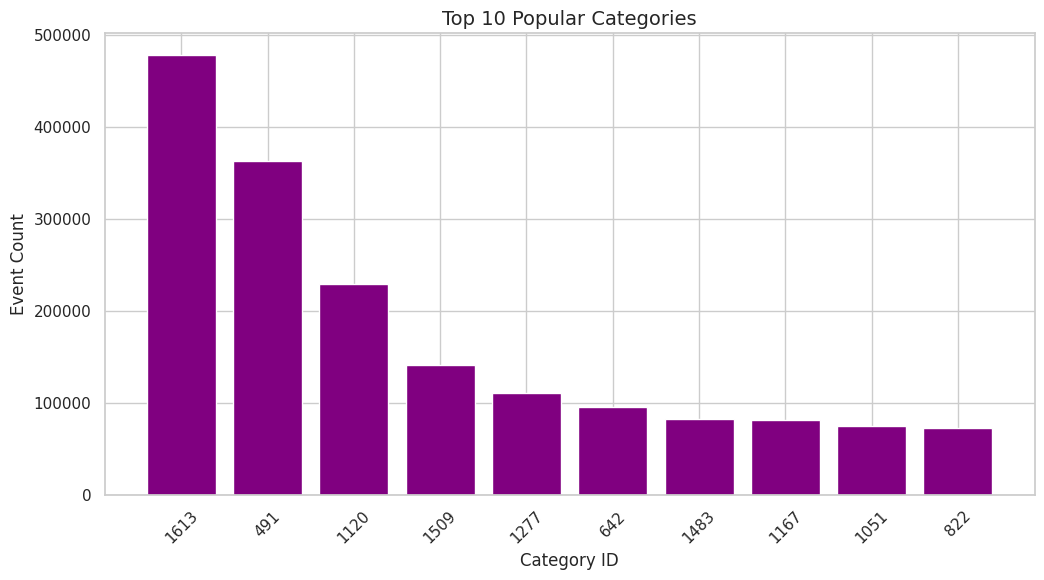

In [17]:
events_with_properties = events.join(
    item_properties.filter(pl.col("property") == "categoryid"),
    on="itemid",
    how="inner",
)
category_popularity = (
    events_with_properties.group_by("value")  # value = categoryid
    .agg(pl.count("event").alias("event_count"))
    .sort("event_count", descending=True)
)
print(category_popularity)



category_popularity_df = category_popularity.head(10).to_pandas()
plt.figure(figsize=(12, 6))
plt.bar(category_popularity_df["value"].astype(str), category_popularity_df["event_count"], color='purple')
plt.title("Top 10 Popular Categories", fontsize=14)
plt.xlabel("Category ID", fontsize=12)
plt.ylabel("Event Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()


Inventory Planning Insights

- Analyze time trends for top-selling products:



In [18]:
product_trends = (
    events_copy.filter(pl.col("event") == "transaction")  # Ensure the event name is correct
    .with_columns(
        pl.col("timestamp")
        .cast(pl.Datetime("ms"))  # Convert Unix timestamp (milliseconds) to datetime
        .dt.date()
        .alias("date")
    )
    .group_by(["date", "itemid"])  # Correct spelling of `groupby`
    .agg(pl.count("event").alias("daily_sales"))
    .sort(["date", "daily_sales"], descending=True)
)
print(product_trends)

shape: (20_655, 3)
┌────────────┬────────┬─────────────┐
│ date       ┆ itemid ┆ daily_sales │
│ ---        ┆ ---    ┆ ---         │
│ date       ┆ i64    ┆ u32         │
╞════════════╪════════╪═════════════╡
│ 2015-09-18 ┆ 122984 ┆ 1           │
│ 2015-09-18 ┆ 312594 ┆ 1           │
│ 2015-09-18 ┆ 334401 ┆ 1           │
│ 2015-09-18 ┆ 342659 ┆ 1           │
│ 2015-09-18 ┆ 213213 ┆ 1           │
│ …          ┆ …      ┆ …           │
│ 2015-05-03 ┆ 445106 ┆ 1           │
│ 2015-05-03 ┆ 90360  ┆ 1           │
│ 2015-05-03 ┆ 301359 ┆ 1           │
│ 2015-05-03 ┆ 29877  ┆ 1           │
│ 2015-05-03 ┆ 158834 ┆ 1           │
└────────────┴────────┴─────────────┘


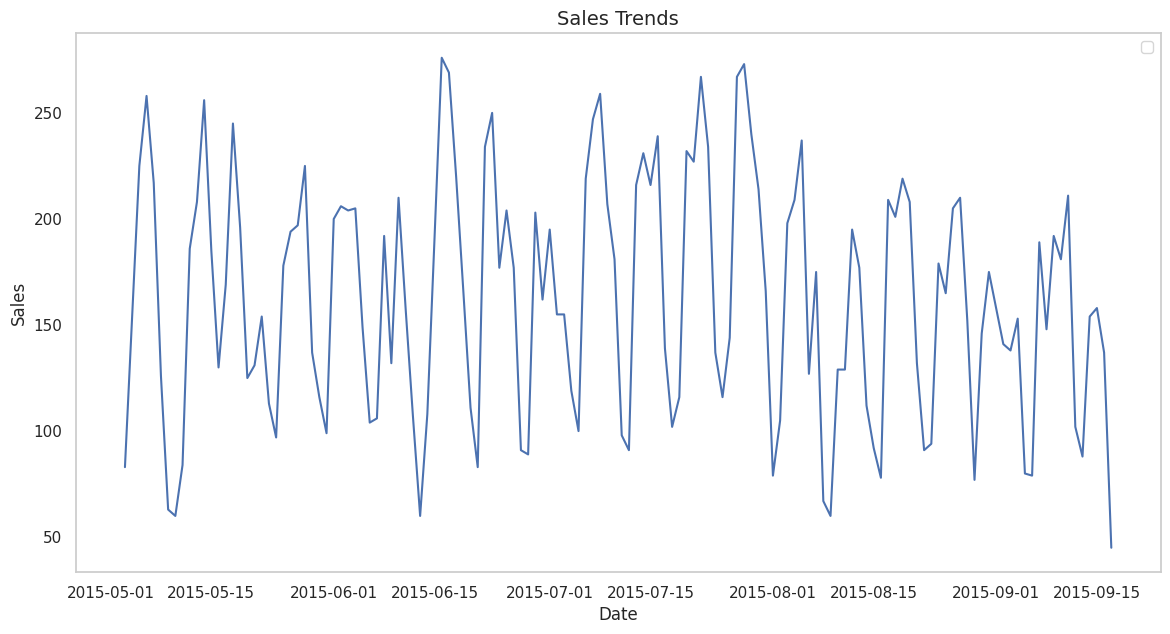

In [19]:
# Convert to pandas
product_trends_df = product_trends.to_pandas()

# Sort the data by date for better plotting
product_trends_df = product_trends_df.sort_values("date")

# Get the top 5 items by total sales
sales_daily = product_trends_df.groupby("date")["daily_sales"].sum()[:-1]

# Plot the trends
plt.figure(figsize=(14, 7))
plt.plot( sales_daily)

plt.title("Sales Trends", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.grid()
plt.show()
